In [23]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, fbeta_score


In [24]:
df = pd.read_csv('labels.csv')


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [26]:
loaded_data = np.load("hyb_emb.npz")
embeddings = {key: loaded_data[key] for key in loaded_data}

In [27]:
train_labels=pd.read_csv('train_pairs.csv')

ast_pairs_train = []
labels_train = []

for _, row in train_labels.iterrows():  
    temp = row['sub'].split('_')

    if temp[0] in embeddings.keys() and temp[1] in embeddings.keys():
        ast1 = embeddings[temp[0]]
        ast2 = embeddings[temp[1]]
        ast_pairs_train.append((ast1, ast2))
        result = df[(df['sub1'] == temp[0]) & (df['sub2'] == temp[1])]
        labels_train.append(result['verdict'].iloc[0])
    else:
        print("Error in ",temp[0]," ",temp[1])

test_labels = pd.read_csv('test_pairs.csv')

print(" ")

ast_pairs_test = []
labels_test = []

for _,row in test_labels.iterrows():
    temp = row['sub'].split('_')

    if temp[0] in embeddings.keys() and temp[1] in embeddings.keys():
        ast1 = embeddings[temp[0]]
        ast2 = embeddings[temp[1]]
        ast_pairs_test.append((ast1,ast2))
        result = df[(df['sub1'] == temp[0]) & (df['sub2'] == temp[1])]
        labels_test.append(result['verdict'].iloc[0])
    else:
        print("Error in ",temp[0]," ",temp[1])
   

In [28]:
class CodePlagiarismDataset(Dataset):
    def __init__(self,embed,lab):
        self.embeddings1 = np.array([e[0] for e in embed])  # Convert string to array
        self.embeddings2 = np.array([e[1] for e in embed])
        self.labels = np.array(lab).astype(np.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        emb1 = torch.tensor(self.embeddings1[idx], dtype=torch.float32)
        emb2 = torch.tensor(self.embeddings2[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        return emb1, emb2, label  

In [29]:
class SiamesePlagiarismClassifier(nn.Module):
    def __init__(self, input_size=1024):  # Updated input size
        super(SiamesePlagiarismClassifier, self).__init__()

        self.shared_fc = nn.Sequential(
            nn.Linear(input_size, 512),  # Reduce from 896 to 512
            nn.BatchNorm1d(512),  # Batch Normalization for stability
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),  
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),  
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),  
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
        
        )

        self.out = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, emb1, emb2):
        emb1 = self.shared_fc(emb1)
        emb2 = self.shared_fc(emb2)
        similarity = torch.abs(emb1 - emb2)
        return self.sigmoid(self.out(similarity))


In [30]:
test_dataset = CodePlagiarismDataset(ast_pairs_train,labels_train)
train_dataset = CodePlagiarismDataset(ast_pairs_test,labels_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [31]:
problem_id = 10  

problem_files = set()
problem_df = df[df['problem'] == problem_id]
for _, row in problem_df.iterrows():
    problem_files.add(row['sub1'])
    problem_files.add(row['sub2'])
problem_files = list(problem_files)
print(f"Found {len(problem_files)} files for problem {problem_id}")

Found 20 files for problem 10


In [32]:
# Generate all possible pairs
import itertools
all_pairs = list(itertools.combinations(problem_files, 2))

# Filter valid pairs with existing embeddings
valid_pairs = []
for pair in all_pairs:
    if pair[0] in embeddings and pair[1] in embeddings:
        valid_pairs.append(pair)
    else:
        print(f"Skipping pair {pair} due to missing embeddings")

In [33]:
len(valid_pairs)

190

In [34]:
class PredictionDataset(Dataset):
    def __init__(self, embed_pairs):
        self.embeddings1 = np.array([e[0] for e in embed_pairs])
        self.embeddings2 = np.array([e[1] for e in embed_pairs])

    def __len__(self):
        return len(self.embeddings1)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.embeddings1[idx], dtype=torch.float32),
            torch.tensor(self.embeddings2[idx], dtype=torch.float32)
        )

In [35]:
pair_embeddings = [(embeddings[p1], embeddings[p2]) for p1, p2 in valid_pairs]
pred_loader = DataLoader(PredictionDataset(pair_embeddings), batch_size=32, shuffle=False)

In [36]:
model = SiamesePlagiarismClassifier().to(device)
model.load_state_dict(torch.load('100_hyb.pth', map_location=device))

predictions = []
with torch.no_grad():
    for emb1, emb2 in pred_loader:
        emb1, emb2 = emb1.to(device), emb2.to(device)
        outputs = model(emb1, emb2).squeeze()
        predictions.extend(outputs.float().cpu().numpy().tolist())

In [37]:
G = nx.Graph()

for file in problem_files:
    if file in embeddings:
        G.add_node(file)

for (p1, p2), pred in zip(valid_pairs, predictions):
    if pred > 0.99:
        G.add_edge(p1, p2, weight=pred)

In [38]:
nodes = list(G.nodes())
node_index = {node: i for i, node in enumerate(nodes)}
adj_matrix = np.zeros((len(nodes), len(nodes)))
for u, v in G.edges():
    i, j = node_index[u], node_index[v]
    adj_matrix[i][j] = adj_matrix[j][i] = 1

distance_matrix = 1 - adj_matrix

dbscan = DBSCAN(eps=0.9,min_samples=2, metric='precomputed', n_jobs=-1)
labels = dbscan.fit_predict(distance_matrix)

print(labels)
print(nodes)

[-1  0 -1  0  0  0 -1  0  0 -1 -1  0 -1  0  0  0  0 -1  0  0]
['0e87b87f', 'd20e861b', 'da54dec3', 'ce7027ee', '976fe834', '6946f466', 'f1540246', '6369a7a2', '016510dc', '90d0ffd0', 'd6af96bd', 'e2e37533', '0d4d22e0', 'bd3051e3', 'db8d728d', '2fdcf0ad', 'f898cee0', '34cd5b66', '4a1573d6', 'b21c7532']


Cluster 1: ['0e87b87f']
Cluster 0: ['d20e861b', 'ce7027ee', '976fe834', '6946f466', '6369a7a2', '016510dc', 'e2e37533', 'bd3051e3', 'db8d728d', '2fdcf0ad', 'f898cee0', '4a1573d6', 'b21c7532']
Cluster 2: ['da54dec3']
Cluster 3: ['f1540246']
Cluster 4: ['90d0ffd0']
Cluster 5: ['d6af96bd']
Cluster 6: ['0d4d22e0']
Cluster 7: ['34cd5b66']


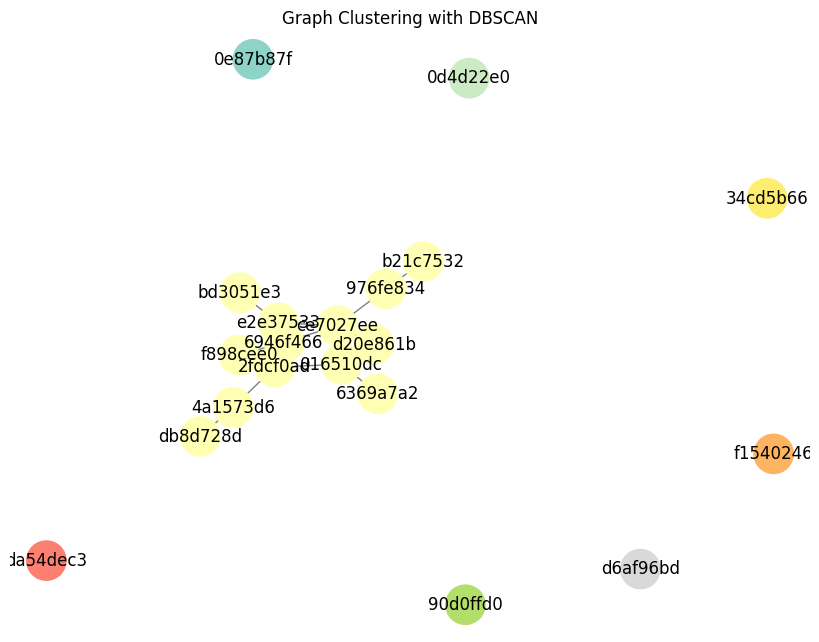

In [39]:
node_labels = {node: label for node, label in zip(nodes, labels)}

from collections import defaultdict

updated_node_labels = node_labels.copy()

next_cluster_id = max(updated_node_labels.values()) + 1

for node, label in updated_node_labels.items():
    if label == -1:
        updated_node_labels[node] = next_cluster_id
        next_cluster_id += 1

clusters = defaultdict(list)
for node, label in updated_node_labels.items():
    clusters[label].append(node)

for label, cluster_nodes in clusters.items():
    print(f"Cluster {label}: {cluster_nodes}")

unique_labels = clusters.keys()
label_to_color = {label: idx for idx, label in enumerate(unique_labels)}
node_colors = [label_to_color[updated_node_labels[node]] for node in G.nodes()]

# Plot graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    node_size=800,
    cmap=plt.cm.Set3,  # You can change to 'tab20', 'nipy_spectral', etc.
    edge_color='gray'
)
plt.title("Graph Clustering with DBSCAN")
plt.show()
